# Predictive Policing in SF - a toy WMD

## For a blog post explaining the motivation behind this project and an interactive map with the predictions visit:

 http://www.orlandotorres.org/predictive-policing-sf.html

In [1]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
import geopandas
from shapely.geometry import Point
import numpy as np
import pandas as pd
#import statsmodels.formula.api as sm
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
from IPython.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))
pd.options.mode.chained_assignment = None

In [2]:
crime17 = pd.read_csv('sf_incidents17.csv')
crime16 = pd.read_csv('sf_incidents16.csv')

### Find the zip codes for each incident given the latitude and longitude

In [3]:
crime16['geometry'] = crime16.apply(lambda row: Point(row['X'], row['Y']), axis=1)

In [4]:
geo_police_data = geopandas.GeoDataFrame(crime16, geometry='geometry')
#geo_police_data.crs = {'init': 'epsg:4326'}
geo_police_data.set_crs("EPSG:4326", inplace=True)

,IncidntNum,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,X,Y,Location,PdId,geometry
0,120058272,WEAPON LAWS,POSS OF PROHIBITED WEAPON,Friday,01/29/2016 12:00:00 AM,11:00,SOUTHERN,"ARREST, BOOKED",800 Block of BRYANT ST,-122.403405,37.775421,"(37.775420706711, -122.403404791479)",12005827212120,POINT (-122.4034 37.77542)
1,120058272,WEAPON LAWS,"FIREARM, LOADED, IN VEHICLE, POSSESSION OR USE",Friday,01/29/2016 12:00:00 AM,11:00,SOUTHERN,"ARREST, BOOKED",800 Block of BRYANT ST,-122.403405,37.775421,"(37.775420706711, -122.403404791479)",12005827212168,POINT (-122.4034 37.77542)
2,160147073,VEHICLE THEFT,STOLEN MOTORCYCLE,Thursday,02/18/2016 12:00:00 AM,22:00,NORTHERN,UNFOUNDED,BROADWAY ST / GOUGH ST,-122.426703,37.795316,"(37.7953163162613, -122.426702502506)",16014707307023,POINT (-122.4267 37.79532)
3,160802233,NON-CRIMINAL,LOST PROPERTY,Monday,10/03/2016 12:00:00 AM,01:18,SOUTHERN,NONE,800 Block of MARKET ST,-122.407902,37.784253,"(37.784253176872, -122.407902468508)",16080223371000,POINT (-122.4079 37.78425)
4,141059263,WARRANTS,WARRANT ARREST,Monday,04/25/2016 12:00:00 AM,14:59,BAYVIEW,"ARREST, BOOKED",KEITH ST / SHAFTER AV,-122.388856,37.729981,"(37.7299809672996, -122.388856204292)",14105926363010,POINT (-122.38886 37.72998)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150723,161061000,ASSAULT,BATTERY,Friday,12/30/2016 12:00:00 AM,21:01,PARK,NONE,OAK ST / STANYAN ST,-122.453982,37.771428,"(37.7714278595913, -122.453981622365)",16106100004134,POINT (-122.45398 37.77143)
150724,176000742,NON-CRIMINAL,LOST PROPERTY,Friday,12/30/2016 12:00:00 AM,08:00,CENTRAL,NONE,JACKSON ST / SANSOME ST,-122.401857,37.796626,"(37.7966261239618, -122.401857374739)",17600074271000,POINT (-122.40186 37.79663)
150725,176000758,LARCENY/THEFT,PETTY THEFT OF PROPERTY,Thursday,12/29/2016 12:00:00 AM,20:00,CENTRAL,NONE,PINE ST / TAYLOR ST,-122.412269,37.790673,"(37.7906727649886, -122.41226909106)",17600075806372,POINT (-122.41227 37.79067)
150726,176000764,LARCENY/THEFT,GRAND THEFT OF PROPERTY,Friday,12/30/2016 12:00:00 AM,10:00,CENTRAL,NONE,200 Block of STOCKTON ST,-122.406659,37.788275,"(37.7882745285785, -122.406658711008)",17600076406374,POINT (-122.40666 37.78827)


In [5]:
sf = geopandas.read_file('zipcodes_geo.json')
sf.set_crs("EPSG:4326", inplace=True)
sf = sf.set_geometry('geometry')

In [6]:
crime16 = geopandas.tools.sjoin(geo_police_data, sf, how='left')

### Find which zip codes, day of week, and hour have the most crimes

In [7]:
day_time_zip_16 = crime16[['Date', 'DayOfWeek', 'Time', 'zip']]

In [8]:
#day_time_zip_16.loc[:, 'Date'] = pd.to_datetime(day_time_zip_16['Date'])
#day_time_zip_16.loc[:, 'Hour'] = pd.to_datetime(day_time_zip_16['Time'])
#day_time_zip_16.loc[:, 'Hour'] = day_time_zip_16.Hour.apply(lambda x: x.hour)

# Convert 'Date' column with full datetime
day_time_zip_16.loc[:, 'Date'] = pd.to_datetime(day_time_zip_16['Date'], format='%m/%d/%Y %I:%M:%S %p', errors='coerce')

# Convert 'Time' and extract hour safely
day_time_zip_16.loc[:, 'Parsed_Time'] = pd.to_datetime(day_time_zip_16['Time'], format='%H:%M', errors='coerce')
day_time_zip_16.loc[:, 'Hour'] = day_time_zip_16['Parsed_Time'].dt.hour.astype('Int64')  # Nullable int


In [9]:
day_time_zip_16.head()

,Date,DayOfWeek,Time,zip,Parsed_Time,Hour
0,2016-01-29 00:00:00,Friday,11:00,94103,1900-01-01 11:00:00,11
1,2016-01-29 00:00:00,Friday,11:00,94103,1900-01-01 11:00:00,11
2,2016-02-18 00:00:00,Thursday,22:00,94109,1900-01-01 22:00:00,22
3,2016-10-03 00:00:00,Monday,01:18,94102,1900-01-01 01:18:00,1
4,2016-04-25 00:00:00,Monday,14:59,94124,1900-01-01 14:59:00,14


## Remove data from November and December because I don't have that data for 2017 to compare it to

In [10]:
#day_time_zip_16_final = day_time_zip_16[day_time_zip_16.Date.dt.month < 11]
day_time_zip_16['Date'] = pd.to_datetime(day_time_zip_16['Date'], errors='coerce')
day_time_zip_16_final = day_time_zip_16[day_time_zip_16['Date'].dt.month < 11]

## Combine all the crimes into hours and days and zip codes

In [11]:
day_time_zip_16_final = day_time_zip_16[['DayOfWeek', 'zip', 'Hour']]

In [12]:
day_time_zip_16_final.loc[:, 'Crimes'] = 1

In [13]:
hour_totals_16 = day_time_zip_16_final.groupby(['DayOfWeek', 'zip', 'Hour']).sum().reset_index()

In [14]:
hour_totals_16.sort_values('Crimes', ascending = False).head()

,DayOfWeek,zip,Hour,Crimes
41,Friday,94103,17,265
650,Monday,94103,17,258
2482,Thursday,94103,18,257
3699,Wednesday,94103,18,257
42,Friday,94103,18,253


## Create dummy variables to start doing analysis

In [15]:
hour_totals_16 = hour_totals_16[['Crimes', 'Hour', 'DayOfWeek', 'zip']]

In [16]:
totals_dummies_16 = pd.get_dummies(hour_totals_16)

In [17]:
#X_16 = totals_dummies_16.iloc[:, 1:]
#y_16 = totals_dummies_16.iloc[:, 0]

X_16 = totals_dummies_16.drop(columns=['Crimes'])  # all predictors
y_16 = totals_dummies_16['Crimes']  # target

# Convert all data to numeric numpy arrays (required by statsmodels)
X_16_np = X_16.apply(pd.to_numeric, errors='coerce').astype(float).values
y_16_np = pd.to_numeric(y_16, errors='coerce').astype(float).values

# Check for NaNs and drop them if any (optional safety step)
valid_rows = ~np.isnan(X_16_np).any(axis=1) & ~np.isnan(y_16_np)
X_16_np = X_16_np[valid_rows]
y_16_np = y_16_np[valid_rows]

## Linear Regression with 2016 data

In [18]:
#linear_regression = sm.OLS(y_16, X_16)
#results = linear_regression.fit()

# Fit OLS model
linear_regression = sm.OLS(y_16_np, X_16_np)
results = linear_regression.fit()

In [19]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.759
Model:                            OLS   Adj. R-squared:                  0.757
Method:                 Least Squares   F-statistic:                     416.8
Date:                Tue, 23 Sep 2025   Prob (F-statistic):               0.00
Time:                        18:31:04   Log-Likelihood:                -18432.
No. Observations:                4262   AIC:                         3.693e+04
Df Residuals:                    4229   BIC:                         3.714e+04
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.4119      0.041     34.673      0.000       1.332       1.492
x2            17.4704      0.813     21.484      0.000      15.876      19.065
x3            13.2707      0.815     16.281      0.000      11.673      14.869
x4            15.4647      0.813     19.017      0.000      13.870      17.059
x5            12.2682      0.809     15.159      0.000      10.682      13.855
x6            14.1285      0.814     17.355      0.000      12.532      15.725
x7            13.8876      0.815     17.037      0.000      12.290      15.486
x8            14.0806      0.817     17.232      0.000      12.479      15.683
x9            60.7649      1.393     43.616      0.000      58.034      63.496
x10          113.8006      1.393     81.684      0.000     111.069     116.532
x11          -26.1413      1.474    -17.729      0.000     -29.032     -23.250
x12          -11.3363      1.393     -8.137      0.000     -14.068      -8.605
x13           12.9018      1.393      9.261      0.000      10.170      15.633
x14           -7.8244      1.393     -5.616      0.000     -10.556      -5.093
x15           35.1161      1.393     25.206      0.000      32.385      37.847
x16           51.0625      1.393     36.652      0.000      48.331      53.794
x17          -13.1844      1.410     -9.349      0.000     -15.949     -10.420
x18            9.2530      1.393      6.642      0.000       6.522      11.984
x19           -1.1756      1.393     -0.844      0.399      -3.907       1.556
x20            7.2173      1.393      5.180      0.000       4.486       9.949
x21          -14.4038      1.402    -10.277      0.000     -17.152     -11.656
x22            3.0863      1.393      2.215      0.027       0.355       5.818
x23           -6.7529      1.393     -4.847      0.000      -9.484      -4.022
x24          -11.1970      1.406     -7.965      0.000     -13.953      -8.441
x25           -2.2113      1.393     -1.587      0.113      -4.943       0.520
x26           -8.8429      1.397     -6.328      0.000     -11.582      -6.103
x27           20.7411      1.393     14.888      0.000      18.010      23.472
x28          -23.5779      1.432    -16.462      0.000     -26.386     -20.770
x29          -29.4819      1.658    -17.786      0.000     -32.732     -26.232
x30          -18.0510      1.410    -12.802      0.000     -20.815     -15.287
x31          -11.4256      1.393     -8.201      0.000     -14.157      -8.694
x32            7.7113      1.393      5.535      0.000       4.980      10.443
x33           -9.3663      1.397     -6.703      0.000     -12.106      -6.627
x34          -26.1119      1.455    -17.949      0.000     -28.964     -23.260
==============================================================================
Omnibus:                      624.519   Durbin-Watson:                   0.765
Pr

# Test it with new 2017 data

### Find the zip codes for each incident given the latitude and longitude

In [20]:
crime17['geometry'] = crime17.apply(lambda row: Point(row['X'], row['Y']), axis=1)

In [21]:
geo_police_data = geopandas.GeoDataFrame(crime17, geometry='geometry')
#geo_police_data.crs = {'init': 'epsg:4326'}
geo_police_data.set_crs("EPSG:4326", inplace=True)

,IncidntNum,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,X,Y,Location,PdId,geometry
0,150333505,WARRANTS,WARRANT ARREST,Wednesday,04/19/2017,21:29,MISSION,"ARREST, BOOKED",24TH ST / BRYANT ST,-122.409132,37.752797,"(37.752796998558445, -122.40913193948903)",15033350563010,POINT (-122.40913 37.7528)
1,141091334,BURGLARY,"BURGLARY OF STORE, FORCIBLE ENTRY",Wednesday,03/08/2017,14:28,SOUTHERN,NONE,800 Block of BRYANT ST,-122.403405,37.775421,"(37.775420706711, -122.40340479147905)",14109133405051,POINT (-122.4034 37.77542)
2,160913272,SUSPICIOUS OCC,SUSPICIOUS OCCURRENCE,Tuesday,09/12/2017,09:00,MISSION,UNFOUNDED,2700 Block of 16TH ST,-122.414223,37.765325,"(37.76532508532617, -122.414222704763)",16091327264070,POINT (-122.41422 37.76533)
3,150045716,WEAPON LAWS,POSS OF FIREARM BY CONVICTED FELON/ADDICT/ALIEN,Thursday,06/01/2017,08:51,INGLESIDE,"ARREST, BOOKED",100 Block of BALTIMORE WY,-122.431842,37.709107,"(37.70910662750824, -122.43184152371002)",15004571612080,POINT (-122.43184 37.70911)
4,150333505,WEAPON LAWS,POSS OF FIREARM BY CONVICTED FELON/ADDICT/ALIEN,Wednesday,04/19/2017,21:29,MISSION,"ARREST, BOOKED",24TH ST / BRYANT ST,-122.409132,37.752797,"(37.752796998558445, -122.40913193948903)",15033350512080,POINT (-122.40913 37.7528)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121699,170106724,ASSAULT,BATTERY,Tuesday,02/07/2017,10:08,TENDERLOIN,NONE,TURK ST / HYDE ST,-122.415695,37.782585,"(37.78258519684673, -122.41569492213362)",17010672404134,POINT (-122.41569 37.78259)
121700,170115747,ASSAULT,BATTERY,Friday,02/10/2017,10:28,MISSION,NONE,1600 Block of BRYANT ST,-122.410478,37.766246,"(37.76624632091369, -122.41047806948747)",17011574704134,POINT (-122.41048 37.76625)
121701,170177565,ASSAULT,BATTERY,Wednesday,03/01/2017,00:01,SOUTHERN,NONE,MISSION ST / 4TH ST,-122.404270,37.784479,"(37.784478853874475, -122.40427017948574)",17017756504134,POINT (-122.40427 37.78448)
121702,170183506,VEHICLE THEFT,STOLEN TRUCK,Friday,03/03/2017,20:30,PARK,NONE,1400 Block of GROVE ST,-122.440483,37.775553,"(37.77555290168326, -122.44048310699829)",17018350607025,POINT (-122.44048 37.77555)


In [22]:
sf = geopandas.read_file('zipcodes_geo.json') #correct the file name
#sf.crs = {'init': 'epsg:4326'}
sf.set_crs("EPSG:4326", inplace=True)
sf = sf.set_geometry('geometry')

In [23]:
crime17 = geopandas.tools.sjoin(geo_police_data, sf, how='left')

### Find which zip codes, day of week, and hour have the most crimes

In [24]:
day_time_zip_17 = crime17[['DayOfWeek', 'Time', 'zip']]

In [25]:
#day_time_zip_17['Hour'] = pd.to_datetime(day_time_zip_17['Time'])
#day_time_zip_17['Hour'] = day_time_zip_17.Hour.apply(lambda x: x.hour)

# Parse the 'Time' column with specified format
day_time_zip_17['Parsed_Time'] = pd.to_datetime(day_time_zip_17['Time'], format='%H:%M', errors='coerce')

# Extract hour as nullable integer
day_time_zip_17['Hour'] = day_time_zip_17['Parsed_Time'].dt.hour.astype('Int64')  # Nullable integer type


## Combine all the crimes into hours and days and zip codes

In [26]:
day_time_zip_17 = day_time_zip_17[['DayOfWeek', 'zip', 'Hour']]

In [27]:
day_time_zip_17['Crimes'] = 1

In [28]:
hour_totals_17 = day_time_zip_17.groupby(['DayOfWeek', 'zip', 'Hour']).count().reset_index()

In [29]:
hour_totals_17.sort_values('Crimes', ascending = False).head()

,DayOfWeek,zip,Hour,Crimes
2465,Thursday,94103,18,227
2466,Thursday,94103,19,220
3067,Tuesday,94103,18,213
41,Friday,94103,17,213
44,Friday,94103,20,201


## Create dummy variables to start doing analysis

In [30]:
hour_totals_17 = hour_totals_17[['Crimes', 'Hour', 'DayOfWeek', 'zip']]

In [31]:
totals_dummies_17 = pd.get_dummies(hour_totals_17)

In [32]:
X_17 = totals_dummies_17.iloc[:, 1:]
y_17 = totals_dummies_17.iloc[:, 0]

# Testing the different models

## Linear Regression

In [33]:
linear_regression = LinearRegression()
linear_regression.fit(X_16,y_16)
linear_regression.score(X_17, y_17)

0.6386917837250607

## Random Forest

In [34]:
rf = RandomForestRegressor()
rf.fit(X_16, y_16)
rf.score(X_17,y_17)

0.8081453106592926

In [35]:
list(zip(X_16.columns, rf.feature_importances_))

[('Hour', np.float64(0.24387168468547257)),
 ('DayOfWeek_Friday', np.float64(0.007272523027458507)),
 ('DayOfWeek_Monday', np.float64(0.003874105877969379)),
 ('DayOfWeek_Saturday', np.float64(0.008654205721042455)),
 ('DayOfWeek_Sunday', np.float64(0.0091961190310017)),
 ('DayOfWeek_Thursday', np.float64(0.004059994062008959)),
 ('DayOfWeek_Tuesday', np.float64(0.0036685237377636092)),
 ('DayOfWeek_Wednesday', np.float64(0.00468542258480652)),
 ('zip_94102', np.float64(0.10961916074816222)),
 ('zip_94103', np.float64(0.35319189954154)),
 ('zip_94104', np.float64(0.007012773343098698)),
 ('zip_94105', np.float64(0.0009504707105208057)),
 ('zip_94107', np.float64(0.013948097846849016)),
 ('zip_94108', np.float64(0.0008710329614623431)),
 ('zip_94109', np.float64(0.04722207434920484)),
 ('zip_94110', np.float64(0.08407035568299655)),
 ('zip_94111', np.float64(0.0005437027850987737)),
 ('zip_94112', np.float64(0.011543318819472233)),
 ('zip_94114', np.float64(0.0025640625377919436)),
 ('z

## KNN

In [36]:
knn = KNeighborsRegressor()
knn.fit(X_16, y_16)
knn.score(X_17,y_17)

0.48659024280096075

## SVM

In [37]:
svm = SVR()
svm.fit(X_16, y_16)
svm.score(X_17,y_17)

0.13401392445832772

## XGBoost

In [38]:
xgb = XGBRegressor()
xgb.fit(X_16, y_16)
xgb.score(X_17,y_17)

0.8146436214447021

## MLP Regressor

In [39]:
mlp = MLPRegressor(hidden_layer_sizes = (100,100,100,100), random_state=444)
mlp.fit(X_16,y_16)

MLPRegressor(hidden_layer_sizes=(100, 100, 100, 100), random_state=444)

In [40]:
mlp.score(X_17, y_17)

0.8231209796331259

## Combine predictions and actual results into one dataframe

In [41]:
mlp_predicts = mlp.predict(X_16)

In [42]:
xgb_predicts = xgb.predict(X_16)

In [43]:
hour_totals_17['Predicted_mlp'] = pd.Series(mlp_predicts)
hour_totals_17['Predicted_xgb'] = pd.Series(xgb_predicts)

### Divide by 365 to get the number of crime incidents each day

In [44]:
hour_totals_17['Crimes'] = hour_totals_17['Crimes']/365
hour_totals_17['Predicted_mlp'] = hour_totals_17['Predicted_mlp']/365
hour_totals_17['Predicted_xgb'] = hour_totals_17['Predicted_xgb']/365

In [45]:
hour_totals_17 = np.round(hour_totals_17,2)

In [46]:
os.makedirs("./colombia", exist_ok=True)
hour_totals_17.to_json("./colombia/crime_predictions.json", orient='records', double_precision=2)

## Create a quick Chloropleth map as a sanity check

In [47]:
chloropleth_data = hour_totals_17.merge(sf)
chloropleth_data = geopandas.GeoDataFrame(chloropleth_data, geometry='geometry')
#chloropleth_data.crs = {'init': 'epsg:4326'}
chloropleth_data.set_crs("EPSG:4326", inplace=True)

,Crimes,Hour,DayOfWeek,zip,Predicted_mlp,Predicted_xgb,zip_code,st_area_sh,sqmi,state,pop10_sqmi,st_length_,objectid,po_name,pop2010,id,multigeom,geometry
0,0.23,0,Friday,94102,0.34,0.32,94102,18949880.4889,0.68,CA,59770.6,23763.5377913,62,San Francisco,40644,94102,false,"POLYGON ((-122.40588 37.78572, -122.40598 37.7..."
1,0.13,1,Friday,94102,0.19,0.20,94102,18949880.4889,0.68,CA,59770.6,23763.5377913,62,San Francisco,40644,94102,false,"POLYGON ((-122.40588 37.78572, -122.40598 37.7..."
2,0.14,2,Friday,94102,0.18,0.18,94102,18949880.4889,0.68,CA,59770.6,23763.5377913,62,San Francisco,40644,94102,false,"POLYGON ((-122.40588 37.78572, -122.40598 37.7..."
3,0.05,3,Friday,94102,0.12,0.13,94102,18949880.4889,0.68,CA,59770.6,23763.5377913,62,San Francisco,40644,94102,false,"POLYGON ((-122.40588 37.78572, -122.40598 37.7..."
4,0.07,4,Friday,94102,0.08,0.07,94102,18949880.4889,0.68,CA,59770.6,23763.5377913,62,San Francisco,40644,94102,false,"POLYGON ((-122.40588 37.78572, -122.40598 37.7..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5003,0.01,22,Wednesday,94158,0.06,0.06,94158,13809547.9654,0.5,CA,9522.0,33679.7961734,61,San Francisco,4761,94158,true,"POLYGON ((-122.38389 37.76813, -122.38388 37.7..."
5004,0.01,22,Wednesday,94158,0.06,0.06,94158,13809547.9654,0.5,CA,9522.0,33679.7961734,61,San Francisco,4761,94158,true,"POLYGON ((-122.38328 37.76696, -122.38331 37.7..."
5005,0.00,23,Wednesday,94158,0.06,0.06,94158,13809547.9654,0.5,CA,9522.0,33679.7961734,61,San Francisco,4761,94158,true,"POLYGON ((-122.39082 37.77667, -122.39258 37.7..."
5006,0.00,23,Wednesday,94158,0.06,0.06,94158,13809547.9654,0.5,CA,9522.0,33679.7961734,61,San Francisco,4761,94158,true,"POLYGON ((-122.38389 37.76813, -122.38388 37.7..."


<Axes: >

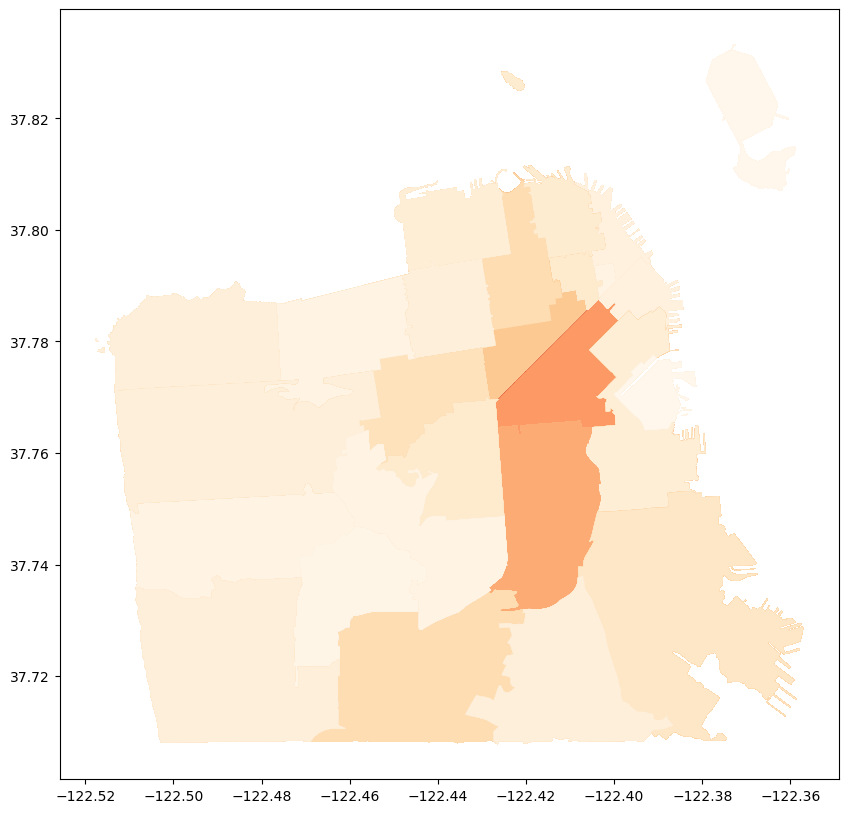

In [48]:
chloropleth_data.plot(column='Crimes', cmap='OrRd', figsize=(13,10))

### The next step is to make an interactive visualization. For this, I will move to D3.js